### AU Mic: A Case Study

In [1]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)
import tqdm
import pandas as pd
import random
import exoplanet
import astropy 
import pymc3
import pymc3_ext
import celerite2
from numpy.linalg import inv, det, solve, cond
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
#from jax import random

1.22.3
1.7.3


In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

path = '/Users/chrislam/Desktop/gaspery/'

#### Functions

In [3]:
def model(t, theta): 
    """
    Radial velocity model, given timestamps and planetary orbital parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]

    """
    
    K, P, T0 = theta[0], theta[1], theta[2]
    arg = (2*np.pi/P)*(t-T0)
    rv = -K * np.sin(arg)
    
    return rv

def partial_mu(t, theta, wrt):
    """
    Unpack parameters and calculate all partial derivatives of the model w.r.t. those parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - wrt: parameter with respect to which the model's partial derivative is taken
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - derivative vector of length N
    """

    # unpack parameters
    K, P, T0 = theta[0], theta[1], theta[2]
    
    # calculate partial derivative depending on 'wrt'
    normalized_t = t-T0
    arg = (2*np.pi/P) * normalized_t
    
    if wrt=='K':
        return -np.sin(arg)
    elif wrt=='P':
        return K * np.cos(arg) * arg/P
    elif wrt=='T0':
        return (2*np.pi*K/P) * np.cos(arg)
    
    print("parameter not recognized")
    
    return                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

def calculate_fim(t, sigma, theta):
    """
    Calculate the generalized Fisher Information Matrix according to I_m,n in 
    https://en.wikipedia.org/wiki/Fisher_information#Multivariate_normal_distribution
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """

    #print("partial mu, partial K: ", partial_mu(t, theta, 'K'))
    #print("partial mu, partial P: ", partial_mu(t, theta, 'P'))
    #print("partial mu, partial T0: ", partial_mu(t, theta, 'T0'))
    factor2 = 1/sigma**2
    factor2[factor2 == np.inf] = 0 
    
    fim = np.zeros((len(theta),len(theta)))
    
    for i in range(len(theta)):
        for j in range(len(theta)):
            #param_i = theta[i]
            #param_j = theta[j]
            wrt_i = param_list[i]
            wrt_j = param_list[j]
            
            factor1 = partial_mu(t, theta, wrt_i)#.reshape((1,4)) # partial derivative of the model wrt row parameter, transposed
            #print(factor1)
            ###factor2 = 1/sigma**2 # inverse of covariance matrix (or just the RV variance if held constant)
            ###factor2[factor2 == np.inf] = 0 # turn infs into zeros (shouldn't it be nans?)
            #print(factor2)
            factor3 = partial_mu(t, theta, wrt_j)#.reshape((4,1)) # partial derivative of the model wrt column parameter
            #print(factor3)
            #print("shapes: ", factor1.shape, factor2.shape, factor3.shape)
            #print(np.dot(np.dot(factor1, factor2), factor3))
            
            fim[i][j] = np.dot(np.dot(factor1, factor2), factor3)
    
    return fim

def calculate_fim_faster(t, sigma, theta):
    """
    Calculate the generalized Fisher Information Matrix by calculating partial derivatives only once
    and then plugging them into the right places. 
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    factor2 = 1/sigma**2
    factor2[factor2 == np.inf] = 0 
    
    partial_k = partial_mu(t, theta, 'K')
    partial_p = partial_mu(t, theta, 'P')
    partial_t = partial_mu(t, theta, 'T0')
    
    fim = np.zeros((len(theta),len(theta)))
    
    for i in range(len(theta)):
        wrt_i = param_list[i]
        if wrt_i=='K':
            factor1 = partial_k
        elif wrt_i=='P':
            factor1 = partial_p
        elif wrt_i=='T0':
            factor1 = partial_t
        
        for j in range(len(theta)):
            wrt_j = param_list[j]
            if wrt_j=='K':
                factor3 = partial_k
            elif wrt_j=='P':
                factor3 = partial_p
            elif wrt_j=='T0':
                factor3 = partial_t
                            
            fim[i][j] = np.dot(np.dot(factor1, factor2), factor3)
    
    return fim

def calculate_fim_array(t, sigma, theta):
    """
    Calculate the generalized Fisher Information Matrix using np.stack instead of nested for loop
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    factor2 = 1/sigma**2
    factor2[factor2 == np.inf] = 0 
    
    partial_k = partial_mu(t, theta, 'K')
    partial_p = partial_mu(t, theta, 'P')
    partial_t = partial_mu(t, theta, 'T0')
    
    #print(np.dot(np.dot(partial_k, factor2), partial_k))
    #print(np.array([np.dot(np.dot(partial_k, factor2), partial_k), np.dot(np.dot(partial_k, factor2), partial_p), np.dot(np.dot(partial_k, factor2), partial_t)]))
    
    fim = np.stack([np.array([np.dot(np.dot(partial_k, factor2), partial_k), np.dot(np.dot(partial_k, factor2), partial_p), np.dot(np.dot(partial_k, factor2), partial_t)]),
                  np.array([np.dot(np.dot(partial_p, factor2), partial_k), np.dot(np.dot(partial_p, factor2), partial_p), np.dot(np.dot(partial_p, factor2), partial_t)]),
                  np.array([np.dot(np.dot(partial_t, factor2), partial_k), np.dot(np.dot(partial_t, factor2), partial_p), np.dot(np.dot(partial_t, factor2), partial_t)])])
    
    return fim

def model_jax(t, K, P, T0): 
    """
    Radial velocity model, given timestamps and planetary orbital parameters, but JAXified
    (basically, np --> jnp)
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]

    """
    
    #K, P, T0 = theta[0], theta[1], theta[2]
    #normalized_t = (t - T0 % P) % P # thanks, Rae! 
    #arg = (2*jnp.pi/P)*(normalized_t)
    
    arg = (2*jnp.pi/P)*(t-T0)
    rv = -K * jnp.sin(arg)
    
    return rv

def calculate_fim_jax(t, sigma, theta):
    """
    Calculate the generalized Fisher Information Matrix using JAX jacfwd to calculate partial derivatives
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """

    factor2 = 1/sigma**2
    factor2[factor2 == np.inf] = 0 
    
    jac = jax.jacfwd(model_jax, argnums=[1,2,3])
    partials = np.array(jac(test_t, float(test_K), float(test_P), float(test_T0)))
    partial_k = partials[0]
    partial_p = partials[1]
    partial_t = partials[2]
    
    fim = np.zeros((len(theta),len(theta)))
    
    for i in range(len(theta)):
        wrt_i = param_list[i]
        if wrt_i=='K':
            factor1 = partial_k
        elif wrt_i=='P':
            factor1 = partial_p
        elif wrt_i=='T0':
            factor1 = partial_t
        
        for j in range(len(theta)):
            wrt_j = param_list[j]
            if wrt_j=='K':
                factor3 = partial_k
            elif wrt_j=='P':
                factor3 = partial_p
            elif wrt_j=='T0':
                factor3 = partial_t
                            
            fim[i][j] = np.dot(np.dot(factor1, factor2), factor3)
    
    return fim

@jax.jit
def dfms_jax_version(t, sigma, theta): # thanks, Dan! 
    """
    Calculate the generalized Fisher Information Matrix using JAX Jacobian.
    Generalizable to arbitrary parameters.
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    def inner(params):
        return model_jax(t, params[0], params[1], params[2])
    
    factor = jnp.where(sigma > 0, 1/sigma**2, 0)    
    J = factor @ jax.jacobian(inner)(theta)
    
    return J.T @ J

In [4]:
### free parameters from Langellier et al 2020
# let's hold these constant for now, but maybe we should sample from the given uncertainties later?
Tau = 23.6 # active region lifetime; days
eta = 0.58 # smoothing parameter
Prot = 28.1 # solar rotation period; days
sigma_qp_rv = 1.44 * 1e2 # U(0.1, 100) * 1e2: 0.5, 1.44, 5. * 1e2 # [cm/s]
sigma_wn_rv = 1.25 * 1e2 # [cm/s]

def cov_matrix(t, params):
    """
    Build a covariance matrix, Sigma, that will be used in the calculation of the Fisher Information Matrix
    
    Inputs:
    - t: time series of length N observations; np.array [day]
    - Tau: active region lifetime [days]; free param taken from Langellier et al 2020
    - eta: smoothing parameter; free param taken from Langellier et al 2020
    - Prot: rotation period [days]; free param taken from Langellier et al 2020
    - sigma_qp_s: correlated noise amplitude; free param taken from Langellier et al 2020
    - sigma_wn_s: white noise amplitude; free param taken from Langellier et al 2020
    
    Outputs:
    - N by N matrix of covariance elements following Equations 1 & 2 of Langellier et al 2020
    
    """
    
    Tau, eta, Prot, sigma_qp_rv, sigma_wn_rv = params[0], params[1], params[2], params[3], params[4]
    
    # create N by N matrix, where N is length of observations time series
    k = np.zeros((len(t),len(t)))
    
    for i in range(len(t)):
        for j in range(len(t)):
            term1 = ((t[i]-t[j])**2)/(2*Tau**2)
            term2 = (1/(2*eta**2)) * (np.sin(np.pi * (t[i] - t[j])/Prot))**2
            arg = -term1 - term2
            k[i][j] = np.exp(arg)
    
    K = sigma_qp_rv**2 * k + sigma_wn_rv**2 * np.diag(np.ones(len(t)))
    
    return K

def cov_matrix_jax(t, params):
    """
    Build a covariance matrix, Sigma, that will be used in the calculation of the Fisher Information Matrix
    
    Inputs:
    - t: time series of length N observations; np.array [day]
    - Tau: active region lifetime [days]; free param taken from Langellier et al 2020
    - eta: smoothing parameter; free param taken from Langellier et al 2020
    - Prot: rotation period [days]; free param taken from Langellier et al 2020
    - sigma_qp_rv: correlated noise amplitude; free param taken from Langellier et al 2020
    - sigma_wn_rv: white noise amplitude; free param taken from Langellier et al 2020
    
    Outputs:
    - N by N matrix of covariance elements following Equations 1 & 2 of Langellier et al 2020
    
    """
    
    Tau, eta, Prot, sigma_qp_rv, sigma_wn_rv = params[0], params[1], params[2], params[3], params[4]
    
    # create N by N matrix, where N is length of observations time series
    k = jnp.zeros((len(t),len(t)))
    
    for i in range(len(t)):
        for j in range(len(t)):
            term1 = ((t[i]-t[j])**2)/(2*Tau**2)
            term2 = (1/(2*eta**2)) * (jnp.sin(jnp.pi * (t[i] - t[j])/Prot))**2
            arg = -term1 - term2
            #k[i][j] = jnp.exp(arg)
            k = jnp.exp(arg)
            #k = k.at[i]
            #x = x.at[idx].set(y)
    
    K = sigma_qp_rv**2 * k + sigma_wn_rv**2 * jnp.diag(np.ones(len(t)))
    #print("shape: ", K.shape)
    
    return K

params = [Tau, eta, Prot, sigma_qp_rv, sigma_wn_rv]

In [5]:
### priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 8.3 #10 # days
start = 2352

test_theta = [test_K, test_P, test_T0]

def make_t(n_obs, cadence, start):
    """
    Gemerate observation times given a number of observations and an average cadence (every X nights)
    
    Input: 
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - start: start time [BJD]
    
    Output:
    - observation times: ndarray
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    end = start + n_obs * cadence 
    t = np.linspace(start, end, n_obs, endpoint=False)
    #print(start, end, n_obs, t)
    
    # add jitter ~ N(0, 1 hr) to timestamps
    t += np.random.normal(0, 1./24)

    return t

def make_t_without_jitter(n_obs, cadence, start):
    """
    Gemerate observation times given a number of observations and an average cadence (every X nights)
    
    Input: 
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - start: start time [BJD]
    
    Output:
    - observation times: ndarray
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    end = start + n_obs * cadence 
    t = np.linspace(2300, end, n_obs, endpoint=False)
    
    return t

def strategy(start, n_obs, cadence, theta, sigma_val=None):
    """
    Allows user to try different n_obs and cadences and visualize how that affects the expected RV semi-amplitude uncertainty, sigma_K
    
    Input: 
    - start: start time from which I build out n_obs * cadence
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - sigma_val: RV measurement uncertainties associated with each observation; float64 [cm/s]
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - sigma_ks: array of sigma_k's calculated by np.linalg.inv [cm/s]
    - sigma_ks_stable: array of sigma_k's calculated by 1/np.sqrt(FIM[0][0])
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    t = make_t(n_obs, cadence, start)
    #print("time steps: ", t)bb
    
    ### make covariance matrix in the scalar, white noise case
    if sigma_val != None:
        sigma_val += 1e-6 # perturb sigma_val to guard against numerical instabilities
        sigma = np.diag(np.ones(len(t))) * sigma_val**2 # covariance matrix of scalar sigma_RV's
        sigma = np.linalg.solve(sigma, np.identity(len(sigma))) # invert to make factor2 for FIM
        
        fim = calculate_fim(t, sigma, theta)
        #print("FIM: ", fim)
        #print("det: ", det(fim))
        inv_fim = inv(fim)
        #print("inv: ", inv_fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        #print("sigma_K, using inv: ", sigma_k)
        #sigma_ks.append(sigma_k)
        sigma_k_stable = np.sqrt(1/fim[0][0])
        #print("sigma_K, not using inv: ", sigma_k_stable)

        # np.linalg.solve is more stable than np.linalg.inv, apparently
        inv_fim_solve = solve(fim, np.diag(np.ones(len(theta)))) 
        sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]
        
        return sigma_k, sigma_k_stable, sigma_k_solve, fim
    
    ### make covariance matrix in the correlated noise case
    else:
        sigma = cov_matrix(t, params)
        sigma += 1e-6 
        sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM
        
        fim = calculate_fim(t, sigma, theta)
        inv_fim = inv(fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        sigma_k_stable = np.sqrt(1/fim[0][0])
        inv_fim_solve = solve(fim, np.diag(np.ones(len(theta)))) 
        sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]
        
        return sigma_k, sigma_k_stable, sigma_k_solve, fim

@jax.jit
def dfms_jax_version(t, sigma, theta): # thanks, Dan! 
    def inner(model_params):
        return model_jax(t, model_params[0], model_params[1], model_params[2])
    
    sigma += 1e-6 # add jitter
    factor = jnp.linalg.solve(sigma, jnp.identity(len(sigma))) # take inverse of covariance matrix
    #factor = jnp.linalg.inv(sigma)
    #factor = jnp.where(sigma > 0, sigma_inv, 0)  
    
    J = jax.jacobian(inner)(theta)
    
    return J.T @ factor @ J

@jax.jit
def jax_fim(t, sigma, theta, stellar_params): 
    """
    Calculate the generalized Fisher Information Matrix using JAX Jacobian.
    Generalizable to arbitrary parameters.
    Now, with second term for correlated noise. 
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - stellar_params: correlated stellar noise parameters, a la Langellier et al 2021; np.array
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    stellar_params breakdown: 
    - Tau: active region lifetime [days]
    - eta: smoothing parameter
    - Prot: rotation period [days]
    - sigma_qp_s: correlated noise amplitude
    - sigma_wn_s: white noise amplitude
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    def inner(params):
        return model_jax(t, params[0], params[1], params[2])
    
    def inner_sigma(t, params):
        return cov_matrix_jax(t, params)
    
    sigma += 1e-6 # add jitter
    factor = jnp.linalg.solve(sigma, jnp.identity(len(sigma))) # take inverse of covariance matrix
    #factor = jnp.linalg.inv(sigma)
    #factor = jnp.where(sigma > 0, sigma_inv, 0)  
    
    J = jax.jacobian(inner)(theta)
    first_term = J.T @ factor @ J
    
    S = jax.jacobian(inner_sigma)(t, stellar_params)
    print("factor: ", factor, factor.shape) # 30 x 30
    print("S: ", S, S.shape) # 30 x 30 x 30
          
    trace_of = factor @ S @ factor @ S
    print("trace of: ", trace_of, trace_of.shape)
    
    second_term = 0.5 * jnp.trace(trace_of)
    print(first_term, first_term.shape)
    print(second_term, second_term.shape)
    
    return first_term + second_term

def strategy_jax(start, n_obs, cadence, theta, sigma_val=None):
    """
    Allows user to try different n_obs and cadences and visualize how that affects the expected RV semi-amplitude uncertainty, sigma_K
    
    Input: 
    - start: start time from which I build out n_obs * cadence
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - sigma_val: RV measurement uncertainties associated with each observation; float64 [cm/s]
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - sigma_ks: array of sigma_k's calculated by np.linalg.inv [cm/s]
    - sigma_ks_stable: array of sigma_k's calculated by 1/np.sqrt(FIM[0][0])
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    t = make_t(n_obs, cadence, start)
    #print("time steps: ", t)
    
    ### make covariance matrix in the scalar, white noise case
    if sigma_val != None:
        sigma_val += 1e-6 # perturb sigma_val to guard against numerical instabilities
        sigma = np.diag(np.ones(len(t))) * sigma_val**2 # covariance matrix of scalar sigma_RV's
        sigma = np.linalg.solve(sigma, np.identity(len(sigma))) # invert to make factor2 for FIM
        
        args = t, sigma, jnp.array(theta, dtype=float)
        fim = dfms_jax_version(*args).block_until_ready()
        
        inv_fim = inv(fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        
        return fim[0][0], sigma_k
    
    ### make covariance matrix in the correlated noise case
    else:
        sigma = cov_matrix(t, params)
        sigma += 1e-6 
        sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM
        
        args = t, sigma, jnp.array(theta, dtype=float)
        fim = dfms_jax_version(*args).block_until_ready()
        
        inv_fim = inv(fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        
        return fim[0][0], sigma_k

print(strategy(start=start, n_obs=100, cadence=1, theta=test_theta, sigma_val=30)) # default to 2300

(0.00015752193337121743, 0.00015747702421094553, 0.00015752193337121743, array([[4.03241852e+07, 1.28581830e+09, 1.36613685e+06],
       [1.28581830e+09, 2.16648661e+14, 2.91178864e+13],
       [1.36613685e+06, 2.91178864e+13, 5.82746853e+12]]))


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_5522/2524423991.py:82: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_5522/2027747029.py:94: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_5522/2027747029.py:102: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


In [6]:
@jax.jit
def clam_jax_fim(t, sigma, theta): 
    """
    Calculate the generalized Fisher Information Matrix using JAX Jacobian.
    Generalizable to arbitrary parameters.
    Now, with second term for correlated noise. 
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - stellar_params: correlated stellar noise parameters, a la Langellier et al 2021; np.array
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    def inner(params):
        return model_jax(t, params[0], params[1], params[2])
    
    sigma += 1e-6 # add jitter
    factor = jnp.linalg.solve(sigma, jnp.identity(len(sigma))) # take inverse of covariance matrix
    #factor = jnp.linalg.inv(sigma)
    #factor[factor == jnp.inf] = 0 
    #factor = jnp.where(sigma > 0, sigma_inv, 0)  
    
    J = jax.jacobian(inner)(theta)
    return J.T @ factor @ J
    

In [7]:
def remove(l,n):
    return np.sort(random.sample(list(l),int(len(l)*(1-n))))

def gappy(n_obs, cadence, start, offs=[], dropout=0.):
    """
    Specify how many nights in a row to observe and how many nights in a row to skip,
    eg. input: {nights on, cadence, percentage of completed observations} 
    
    Input: 
    - n_obs: number of observations to make; this is a fixed goal [int]
    - cadence: amount of time between observations [days]
    - start: start time [BJD]
    - offs: all pairs of off-night spans, described by their start/end times [list of two-element lists of floats]
    - dropout: percent of dropout due to weather and other uniformly distributed unfortunate events
    
    Output:
    - observation times: ndarray of floats
    
    """
    
    total_t = []
    start_temp = start
    n_tot = 0
    n = 0
    
    if len(offs) > 0:
        # keep making observations until you've reached your prescribed budget of observations
        while n_tot < n_obs:
            # allow for multiple spans of off nights
            for off in offs:

                end_temp = off[0]

                # rearrange from end = start + n_obs * cadence to get on chunk
                n = int(np.ceil((end_temp - start_temp)/cadence))
                #print(" start: ", start_temp, "end: ", end_temp, "n_obs: ", n)

                try: # if off != offs[-1]: # if there are yet more offs? 
                    t = np.linspace(start_temp, end_temp, n, endpoint=False)
                    # add jitter ~ N(0, 1 hr) to timestamps
                    t += np.random.normal(0, 1./24)
                    total_t = np.concatenate([total_t, t])
                    n_remaining = n_obs - len(total_t)

                except: # if there aren't, then we just straight shot til n_obs is fulfilled
                    #n_remaining = n_obs - len(total_t)
                    #print("exception")
                    end_temp = start_temp + n_remaining * cadence
                    #print(start_temp, end_temp, n_remaining)
                    t = np.linspace(start_temp, end_temp, n_remaining, endpoint=False)

                    # add jitter ~ N(0, 1 hr) to timestamps
                    t += np.random.normal(0, 1./24)

                    #total_t.append(t)
                    total_t = np.concatenate([total_t, t])

                #print(t)

                # new start time
                start_temp = off[1]

                n_tot = len(total_t)
                #print("N total: ", n_tot)

                if n_tot >= n_obs:
                    break

            # let's say there's no more offs and yet more observations to make
            # Then, we just straight shot til n_obs is fulfilled          

        # pare down total_t if the last concatenation overshoots n_obs
        # I have logic for dealing with that if I get through all off nights
        # But n_obs gets hit before then, this is to take care of that.
        n_extra = n_tot - n_obs
        #print("n extra: ", n_extra)
        if n_extra > 0:
            total_t = total_t[:-n_extra]
    
    else:
        total_t = make_t(n_obs, cadence, start)
        #print("total: ", total_t)
    
    # dropout some observations based on dropout
    total_t = remove(total_t, dropout)
    
    return total_t

#### Visualize RV curve with arbitrary observations

In [8]:
### AU Mic and AU Mic b params: Zicher et al 2022: https://academic.oup.com/mnras/article/512/2/3060/6547782
p = 8.5 # p_c = 18.9 days
Prot = 4.86 # days
K = 580 # cm/s
K_err = 250 # cm/s
T0 = 2360 # BJD

theta = [K, p, T0]

n_obs = 30 # 9
cadence = 2
start = 2352
dropout = 0.1
offs = [[start+14, start+28], [start+42, start+56], [start+70, start+84]]
strat = gappy(n_obs = n_obs, cadence = cadence, start = start, offs = offs, dropout = dropout)
#strat = gappy(n_obs = n_obs, cadence = cadence, start = start)
print(strat, len(strat))


[2352.04002847 2354.04002847 2356.04002847 2358.04002847 2360.04002847
 2362.04002847 2364.04002847 2380.00752438 2382.00752438 2384.00752438
 2386.00752438 2388.00752438 2390.00752438 2408.01624636 2410.01624636
 2412.01624636 2414.01624636 2416.01624636 2418.01624636 2420.01624636
 2435.93158973 2437.93158973 2439.93158973 2441.93158973 2445.93158973
 2447.93158973 2449.93158973] 27


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_5522/1101555960.py:9: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


FIM:  [[ 6.8812736e-04 -3.2026029e-01 -3.5218276e-02]
 [-3.2026026e-01  5.1802979e+03  6.6527289e+02]
 [-3.5218291e-02  6.6527283e+02  1.4320869e+02]]
sigma_k using linalg.inv:  38.69918


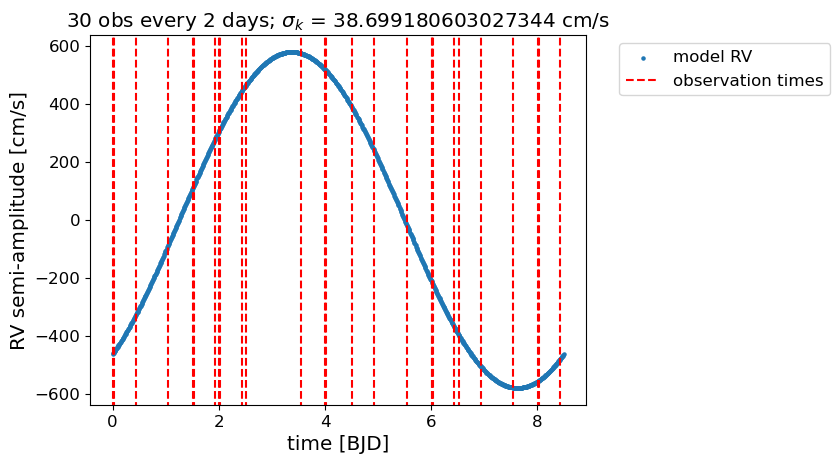

In [9]:
sigma = cov_matrix(strat, params)
sigma += 1e-6 
#sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM

args = np.array(strat), sigma, jnp.array(theta, dtype=float)
fim = clam_jax_fim(*args).block_until_ready()

inv_fim = inv(fim)
sigma_k = np.sqrt(inv_fim)[0][0]
        
#sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=start, n_obs=n_obs, cadence=cadence, theta=test_theta)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
#print("sigma_k using linalg.solve: ", sigma_k_solve)
#print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2352 # BJD
end = 2452 # BJD
t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
t_phase_folded = t % p
#sigma_val = 30+1e-6 # cm/s
#test_sigma = np.ones(len(test_t))*sigma_val
y = model(t, theta)
y_phase_folded = model(t_phase_folded, theta)

### plot observations from strategy
#end = start + cadence * n_obs
#strat = np.linspace(start, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = np.array(strat) % p

plt.scatter(t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {sigma_k} cm/s')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.savefig('plots/strategy4.pdf', format='pdf')
plt.show()

#### Sensitivity maps

In [11]:
# planet observation parameters
#periods = np.linspace(1, 30, 200)
#cadences = np.linspace(1, 7, 200)

# static correlated noise parameters
Tau = 23.6 # active region lifetime; days
eta = 0.58 # smoothing parameter
#sigma_qp_s = 1.43e-3 # correlated noise amplitude [km/s]
#sigma_wn_s = 0.178e-3 # white noise amplitude [km/s]
sigma_qp_rv = 1.44 * 1e2 # [cm/s]
sigma_wn_rv = 1.25 * 1e2 # [cm/s]

### the parameter I'm varying
#Tau = 5 # 5, 30, 50, 100
params = [Tau, eta, Prot, sigma_qp_rv, sigma_wn_rv]

periods = [p]
cadences = np.linspace(0.30, 6.85, 100)
n_obs = 30 #40 # 500
start = 2352

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

sigma_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))
sigma_ks_stable = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))
sigma_ks_solve = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))
fi_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))


for enum_p, p in enumerate(tqdm(periods)):
    for enum_c, c in enumerate(cadences):
        
        theta = [K, p, T0]
        strat = gappy(n_obs = n_obs, cadence = c, start = start)
        #strat = gappy(n_obs = n_obs, cadence = cadence, start = start, offs = offs, dropout = dropout)

        sigma = cov_matrix(strat, params)
        sigma += 1e-6 
        #sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM

        args = np.array(strat), sigma, jnp.array(theta, dtype=float)
        #fim = dfms_jax_version(*args).block_until_ready()
        fim = clam_jax_fim(*args).block_until_ready()
        inv_fim = inv(fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        
        fi_k = fim[0][0]
        
        # for 2D plots and testing
        sigma_ks[enum_p][enum_c] = sigma_k
        ###sigma_ks_stable[enum1][enum2] = sigma_k_stable
        ###sigma_ks_solve[enum1][enum2] = sigma_k_solve
        
        fi_ks[enum_p][enum_c] = fi_k
        

  0%|                                                                                                                                                 | 0/1 [00:00<?, ?it/s]/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_1848/3793871645.py:48: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


In [12]:
Prot

4.86

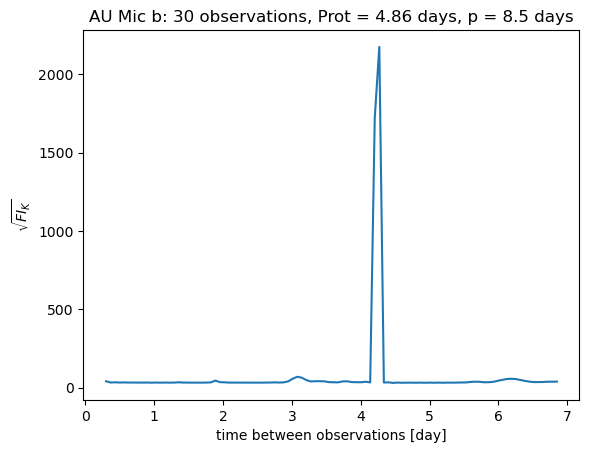

In [13]:
#plt.plot(cadences, np.sqrt(fi_ks[0])) 
plt.plot(cadences, sigma_ks[0]) 
plt.xlabel("time between observations [day]")
plt.ylabel(r'$\sqrt{FI_K}$')
#plt.yscale('log')
plt.title(f"AU Mic b: {n_obs} observations, Prot = {Prot} days, p = {periods[0]} days")
#plt.savefig("plots/au-mic/fim_prot2.pdf", format="pdf")
plt.show()


Makes sense: I don't want to sample every {Prot} days.

### Baseline vs nights-on

In [18]:
def on_vs_baseline_balanced(start, n_obs, on, baseline, perfect_flag=False):
    """
    Construct observing strategy given on nights, baseline, and n_obs.
    Distribute on nights across time series while meeting the prescription.
    
    Inputs: 
    - start: start date [BJD]
    - n_obs: number of observations budgeted for
    - on: number of consecutive nights of observation [days]
    - baseline: overall observing window [days]
    - perfect_flag: if True, only make strategies for combos that have equal numbers of offs in each block
      if False, make strategies for any combo that has off periods = on periods - 1
    
    Returns: 
    - strat: time series of dates of observations [list of floats]
    
    """
    
    # (4, 60)
    temp_start = start
    
    # 8
    n_on_periods = int(np.ceil(n_obs/on))
    
    # skip combinations that don't necessitate a perfectly balanced strat
    #print(baseline - n_obs, n_on_periods - 1, (baseline - n_obs) % (n_on_periods - 1))
    if perfect_flag == True:    
        if (baseline - n_obs) % (n_on_periods - 1) != 0: 
            strat = []
            #print("baseline: ", baseline, "on: ", on)
            return strat
    # at the very least, skip combinations that don't have off periods = on periods - 1
    
    # 7
    n_mixed_periods = int(n_on_periods - 1)
    
    # 8
    #block_length = int(np.floor((baseline - on)/n_mixed_periods))
    block_length = int(np.floor((baseline - n_obs)/n_mixed_periods))
    
    # 4 
    off_length = block_length - on
    
    # 28
    on_total = int(n_mixed_periods * on)
    # 56
    nights_total = int(n_mixed_periods * block_length)
    
    # 2
    on_residual = n_obs - on_total
    # 4
    nights_residual = baseline - nights_total
    
    ### make canvas to poke holes in
    #strat = np.arange(start, start + baseline, 1)
    
    """
    print("ons: ", on, "baseline:", baseline)
    print("mixed periods: ", n_mixed_periods)
    print("block length: ", block_length)
    print("off length: ", off_length)
    print("on total: ", on_total)
    print("nights total: ", nights_total)
    print("on residual: ", on_residual)
    print("nights residual: ", nights_residual)
    print("original strat: ", strat)
    """
    
    ### construct 'on-masks'
    ons = []
    for i in range(n_mixed_periods):
        on_i = np.arange(temp_start, temp_start + on, 1)
        ons.append(on_i)
                        
        temp_start += on
        
        # minimum off block length
        off1 = np.floor((baseline - n_obs)/n_mixed_periods)
        
        # number of off blocks with an extra night
        off2 = (baseline - n_obs) % n_mixed_periods
        
        if i+1 <= off2:
            temp_start += (off1+1)
        else: 
            temp_start += off1
                        
    ### last on block to top off
    ons.append(np.arange(temp_start, temp_start + on_residual, 1))
    
    ### flatten list
    ons = [item for sublist in ons for item in sublist]
    
    """
    print("length of ons: ", len(ons))
    """
    
    return ons

on = 9
baseline = 55
strat = on_vs_baseline_balanced(start, n_obs, on, baseline, perfect_flag=False)
print(strat, len(strat))

# dropout some observations based on dropout
dropout = 0.1
strat = remove(strat, dropout)
print(strat, len(strat))

[2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2358.0, 2359.0, 2360.0, 2361.0, 2362.0, 2363.0, 2364.0, 2365.0, 2366.0, 2364.0, 2365.0, 2366.0, 2367.0, 2368.0, 2369.0, 2370.0, 2371.0, 2372.0, 2370.0, 2371.0, 2372.0, 2373.0, 2374.0, 2375.0, 2376.0, 2377.0, 2378.0, 2376.0, 2377.0, 2378.0, 2379.0, 2380.0, 2381.0, 2382.0, 2383.0, 2384.0, 2382.0, 2383.0, 2384.0, 2385.0, 2386.0, 2387.0, 2388.0, 2389.0, 2390.0, 2388.0, 2389.0, 2390.0, 2391.0, 2392.0, 2393.0, 2394.0, 2395.0, 2396.0, 2394.0, 2395.0, 2396.0, 2397.0, 2398.0, 2399.0, 2400.0, 2401.0, 2402.0, 2400.0, 2401.0, 2402.0, 2403.0, 2404.0, 2405.0, 2406.0, 2407.0, 2408.0, 2405.0, 2406.0] 83
[2352. 2353. 2354. 2355. 2356. 2357. 2358. 2359. 2360. 2360. 2361. 2362.
 2363. 2364. 2364. 2365. 2365. 2366. 2366. 2367. 2368. 2369. 2370. 2370.
 2371. 2371. 2372. 2372. 2373. 2374. 2375. 2376. 2377. 2378. 2378. 2379.
 2381. 2382. 2382. 2383. 2383. 2384. 2384. 2385. 2386. 2387. 2388. 2388.
 2389. 2389. 2390. 2390. 2391. 2392. 2393. 2394. 2394. 239

FIM:  [[ 8.4478786e-04 -4.2645413e-02 -4.2372342e-02]
 [-4.2645410e-02  8.2149042e+02  2.1254977e+02]
 [-4.2372331e-02  2.1254979e+02  1.3089677e+02]]
sigma_k using linalg.inv:  34.71814


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_1848/3555700534.py:9: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


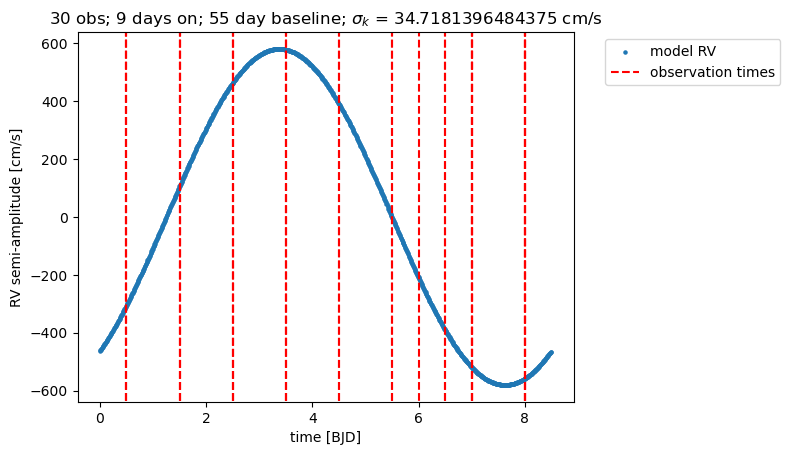

In [15]:
sigma = cov_matrix(strat, params)
sigma += 1e-6 
#sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM

args = np.array(strat), sigma, jnp.array(theta, dtype=float)
fim = clam_jax_fim(*args).block_until_ready()

inv_fim = inv(fim)
sigma_k = np.sqrt(inv_fim)[0][0]
#sigma_k = np.round(sigma_k, 1)
        
#sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=start, n_obs=n_obs, cadence=cadence, theta=test_theta)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
#print("sigma_k using linalg.solve: ", sigma_k_solve)
#print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2352 # BJD
end = 2552 # BJD
t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
t_phase_folded = t % p
#sigma_val = 30+1e-6 # cm/s
#test_sigma = np.ones(len(test_t))*sigma_val
y = model(t, theta)
y_phase_folded = model(t_phase_folded, theta)

### plot observations from strategy
#end = start + cadence * n_obs
#strat = np.linspace(start, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = np.array(strat) % p

plt.scatter(t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs; {on} days on; {baseline} day baseline; ' + r'${\sigma}_k$' + f' = {sigma_k} cm/s')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.savefig(f'plots/regimes/strategy_{on}on_{baseline}baseline_imperfect.png', format='png')
plt.show()

#### Vary stellar parameters

In [16]:
#n_ons = np.linspace(1, 16, 16) # the number of consecutive nights of observing before going to off-mode
#baselines = np.linspace(31, 180, 150) # the total calendar time of the observing campaign (let's say max of 6 months, or 180 days)
#n_ons = np.linspace(3, 16, 14)
#baselines = np.linspace(35, 60, 26) 

# planet observation parameters
#periods = np.linspace(1, 30, 200)
#cadences = np.linspace(1, 7, 200)

# static correlated noise parameters
Tau = 100 # 5, 23.6, 50, 100 # active region lifetime; days
eta = 0.58 # 0.1, 0.3, 0.58, 0.9 # smoothing parameter
#sigma_qp_s = 1.43e-3 # correlated noise amplitude [km/s]
#sigma_wn_s = 0.178e-3 # white noise amplitude [km/s]
#sigma_qp_s = sigma_qp_s * 1e5 # [cm/s]
#sigma_wn_s = sigma_wn_s * 1e5 # [cm/s]
sigma_qp_rv = 1.44 * 1e2 # U(0.1, 100) * 1e2: 0.5, 1.44, 5. * 1e2 # [cm/s]
sigma_wn_rv = 1.25 * 1e2 # [cm/s]

p = 8.5 # p_c = 18.9 days
Prot = 4.86 # days
K = 580 # cm/s

### the parameter I'm varying
params = [Tau, eta, Prot, sigma_qp_rv, sigma_wn_rv]

#periods = [p]
#cadences = np.linspace(0.30, 6.85, 100)
#n_obs = 30 #40 # 500
start = 2352
n_obs = 30
n_ons = np.linspace(1, 16, 16) # the number of consecutive nights of observing before going to off-mode
baselines = np.linspace(30, 180, 151) # the total calendar time of the observing campaign (let's say max of 6 months, or 180 days)
#n_obs = np.linspace(1, 100, 100) # number of observations

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

sigma_ks = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))
sigma_ks_stable = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))
sigma_ks_solve = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))
fi_ks = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))

for enum_b, b in enumerate(tqdm(baselines)):
    for enum_o, o in enumerate(n_ons):
        
        b, o = int(b), int(o)
        
        try:
            strat = on_vs_baseline_balanced(start, n_obs, o, b, perfect_flag=False)
            #print("strat: ", strat, "length: ", len(strat))
        
            ### calculate FI and sigma_K
            if len(strat) == 30:
                sigma = cov_matrix(strat, params)
                sigma += 1e-6 
                #sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM

                args = np.array(strat), sigma, jnp.array(theta, dtype=float)
                #fim = dfms_jax_version(*args).block_until_ready()
                fim = clam_jax_fim(*args).block_until_ready()
                inv_fim = inv(fim)
                sigma_k = np.sqrt(inv_fim)[0][0]

                fi_k = fim[0][0]

                # for 2D plots and testing
                sigma_ks[enum_b][enum_o] = sigma_k
                ###sigma_ks_stable[enum1][enum2] = sigma_k_stable
                ###sigma_ks_solve[enum1][enum2] = sigma_k_solve

                fi_ks[enum_b][enum_o] = fi_k

            else: 
                #print("nights on: ", o, "baseline: ", b)
                #print("offs: ", offs)
                sigma_ks[enum_b][enum_o] = np.nan
                fi_ks[enum_b][enum_o] = 0
                
        except Exception as e:
            #print(e, b, o)
            sigma_ks[enum_b][enum_o] = np.nan
            fi_ks[enum_b][enum_o] = 0

  0%|                                                                                                                                               | 0/151 [00:00<?, ?it/s]/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_1848/1268897417.py:65: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:13<00:00, 11.26it/s]


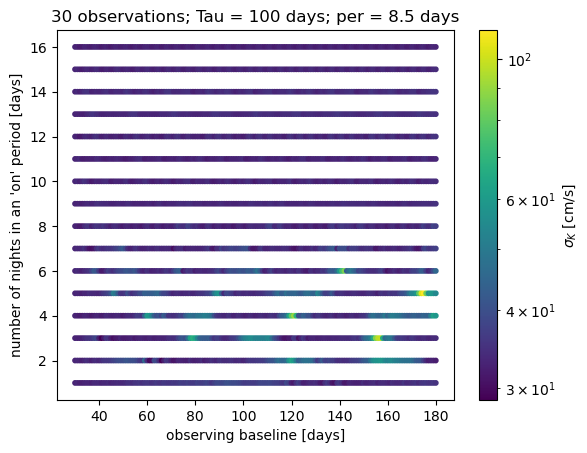

In [17]:
x, y = np.meshgrid(n_ons, baselines)
#plt.scatter(x, y, c=np.sqrt(fi_ks), s=5, norm=matplotlib.colors.LogNorm()) # vmin=1e2, vmax=3e4
#plt.scatter(y, x, c=sigma_ks, s=10, norm=matplotlib.colors.LogNorm(vmin=5, vmax=70)) # vmin=5, vmax=35
plt.scatter(y, x, c=sigma_ks, s=10, norm=matplotlib.colors.LogNorm()) # vmin=5, vmax=35
cbar = plt.colorbar()
#cbar.ax.set_ylabel(r'$\sqrt{FI_K}$')
cbar.ax.set_ylabel(r'$\sigma_K$ [cm/s]')
plt.ylabel("number of nights in an 'on' period [days]")
plt.xlabel("observing baseline [days]")
#plt.yscale('log')
plt.title(f"{n_obs} observations; Tau = {Tau} days; per = {p} days")
#plt.savefig(f"plots/au-mic/tau/on_vs_baseline_tau{int(Tau)}_p8.png", format="png")
plt.show()

### Find min(n_obs) required to reach sigma_K = 10% of K

#### Also, use Klein+ 2021 stellar values for AU Mic b rather than Solar values

Plot baseline vs n_on and color by min(n_obs) needed to reach tolerance. 

In [23]:
"""
# correlated noise parameters, solar values from HARPS
Tau = 23.6 # 5, 23.6, 50, 100 # active region lifetime; days
eta = 0.58 # 0.1, 0.3, 0.58, 0.9 # smoothing parameter
sigma_qp_rv = 1.44 * 1e2 # U(0.1, 100) * 1e2: 0.5, 1.44, 5. * 1e2 # [cm/s]
sigma_wn_rv = 1.25 * 1e2 # [cm/s]
"""

# correlated noise parameters, from Klein+ 2021 for AU Mic
Tau = 100/np.sqrt(2) # active region lifetime; days
eta = 0.4/np.sqrt(2) # 0.1, 0.3, 0.58, 0.9 # smoothing parameter
sigma_qp_rv = 47 * 1e2 # modified Jeffreys prior +11, -8 [cm/s]
sigma_wn_rv = 5 * 1e2 # [cm/s]

# system parameters
p = 8.5 # p_c = 18.9 days
Prot = 4.86 # days
K = 850 # Zicher says 580cm/s +/- 250. But Plavchan says 1450cm/s. And Klein says 850cm/s +230 - 220.
tol = 0.1*K # cm/s

### the parameter I'm varying
params = [Tau, eta, Prot, sigma_qp_rv, sigma_wn_rv]

start = 2352
n_ons = np.linspace(1, 16, 16) # the number of consecutive nights of observing before going to off-mode
baselines = np.linspace(30, 200, 171) # the total calendar time of the observing campaign (let's say max of 6 months, or 180 days)
#n_obs = np.linspace(1, 100, 100) # number of observations

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

sigma_ks = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))
sigma_ks_stable = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))
sigma_ks_solve = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))
fi_ks = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))
n_obs_required = np.ones(len(baselines)*len(n_ons)).reshape((len(baselines),len(n_ons)))

for enum_b, b in enumerate(tqdm(baselines)):
    for enum_o, o in enumerate(n_ons):
        
        b, o = int(b), int(o)
        
        n_obs = 60 #3
        sigma_k = tol+1 # set sigma_k at fiducial value that's always higher than tolerance
        
        while (sigma_k > tol) or (np.isnan(sigma_k) == True):
        
            try:
                strat = on_vs_baseline_balanced(start, n_obs, o, b, perfect_flag=False)
                #print("strat: ", strat, "length: ", len(strat))
                
                ### calculate FI and sigma_K
                sigma = cov_matrix(strat, params)
                sigma += 1e-6 
                #sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM

                args = np.array(strat), sigma, jnp.array(theta, dtype=float)
                fim = clam_jax_fim(*args).block_until_ready()
                inv_fim = inv(fim)
                sigma_k = np.sqrt(inv_fim)[0][0]
                
                fi_k = fim[0][0]

                # for 2D plots and testing
                sigma_ks[enum_b][enum_o] = sigma_k
                ###sigma_ks_stable[enum1][enum2] = sigma_k_stable
                ###sigma_ks_solve[enum1][enum2] = sigma_k_solve

                fi_ks[enum_b][enum_o] = fi_k
                
            except Exception as e:
                #print(e, b, o)
                sigma_ks[enum_b][enum_o] = np.nan #1e5 # np.nan still counts as less than tol for some reason
                fi_ks[enum_b][enum_o] = 0
            
            n_obs += 1
            
            if n_obs > 120: # we don't have forever
                break
                
            if n_obs > b: # we assume that I can't observe more than once per night
                break
                
        #if n_obs <= 70: # what are the best strategies
        #    print("baseline: ", b, "on nights: ", o, "n_obs: ", n_obs, "sigma_K: ", sigma_k)
            
        if n_obs == 120: 
            n_obs_required[enum_b][enum_o] = np.nan
        elif n_obs > b: # we assume that I can't observe more than once per night
            n_obs_required[enum_b][enum_o] = np.nan
        else:
            n_obs_required[enum_b][enum_o] = n_obs-1


  0%|                                                                                                                                               | 0/171 [00:00<?, ?it/s]/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_1848/2867474501.py:62: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 171/171 [2:14:34<00:00, 47.22s/it]


In [24]:
np.nanmin(n_obs_required)

69.0

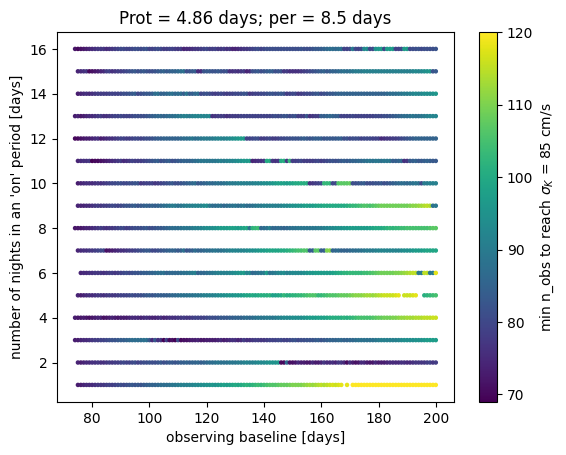

In [424]:
x, y = np.meshgrid(n_ons, baselines)
#plt.scatter(x, y, c=np.sqrt(fi_ks), s=5, norm=matplotlib.colors.LogNorm()) # vmin=1e2, vmax=3e4
#plt.scatter(y, x, c=sigma_ks, s=10, norm=matplotlib.colors.LogNorm(vmin=5, vmax=70)) # vmin=5, vmax=35
plt.scatter(y, x, c=n_obs_required, s=5) # vmin=5, vmax=35
cbar = plt.colorbar()
#cbar.ax.set_ylabel(r'$\sqrt{FI_K}$')
cbar.ax.set_ylabel(r'min n_obs to reach $\sigma_K$ = 85 cm/s')
plt.ylabel("number of nights in an 'on' period [days]")
plt.xlabel("observing baseline [days]")
#plt.yscale('log')
plt.title(f"Prot = {Prot} days; per = {p} days")
#plt.savefig(f"plots/au-mic/min_nobs.png", format="png")
plt.show()

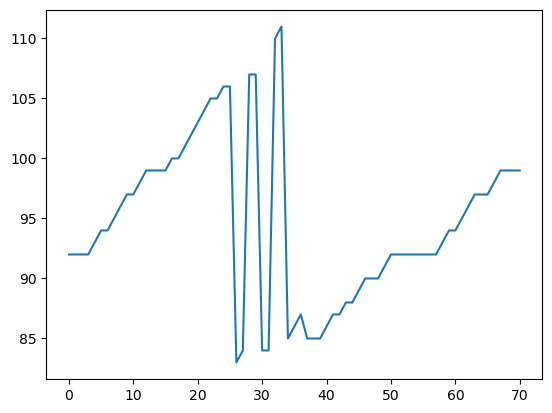

26
107.0
158.0


In [26]:
plt.plot(n_obs_required.T[6][100:])
plt.show()

print(np.argmin(n_obs_required.T[6][100:]))
print(n_obs_required.T[6][128]) # 134
print(baselines[128])

In [27]:
### test bed

n_obs = 83 #72
on = 7
baseline = 158 #75
strat = on_vs_baseline_balanced(start, n_obs, on, baseline, perfect_flag=False)
print("strat: ", strat, "length: ", len(strat))

### calculate FI and sigma_K
sigma = cov_matrix(strat, params)
sigma += 1e-6 
#sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM

args = np.array(strat), sigma, jnp.array(theta, dtype=float)
fim = clam_jax_fim(*args).block_until_ready()
inv_fim = inv(fim)
sigma_k = np.sqrt(inv_fim)[0][0]

fi_k = fim[0][0]
print("sigma_K: ", sigma_k)
print("FI: ", fi_k)

strat:  [2352, 2353, 2354, 2355, 2356, 2357, 2358, 2366.0, 2367.0, 2368.0, 2369.0, 2370.0, 2371.0, 2372.0, 2380.0, 2381.0, 2382.0, 2383.0, 2384.0, 2385.0, 2386.0, 2394.0, 2395.0, 2396.0, 2397.0, 2398.0, 2399.0, 2400.0, 2408.0, 2409.0, 2410.0, 2411.0, 2412.0, 2413.0, 2414.0, 2422.0, 2423.0, 2424.0, 2425.0, 2426.0, 2427.0, 2428.0, 2436.0, 2437.0, 2438.0, 2439.0, 2440.0, 2441.0, 2442.0, 2450.0, 2451.0, 2452.0, 2453.0, 2454.0, 2455.0, 2456.0, 2464.0, 2465.0, 2466.0, 2467.0, 2468.0, 2469.0, 2470.0, 2478.0, 2479.0, 2480.0, 2481.0, 2482.0, 2483.0, 2484.0, 2491.0, 2492.0, 2493.0, 2494.0, 2495.0, 2496.0, 2497.0, 2504.0, 2505.0, 2506.0, 2507.0, 2508.0, 2509.0] length:  83
sigma_K:  89.422714
FI:  0.000125077


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_1848/1194532193.py:17: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


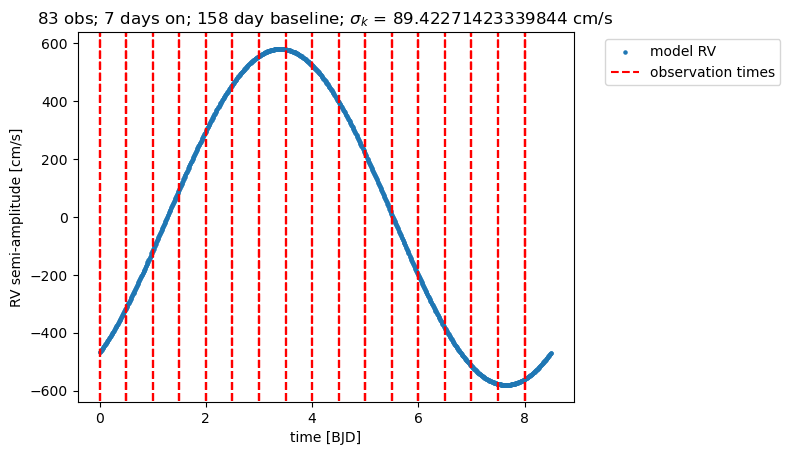

In [28]:
### RV model
start = 2352 # BJD
end = 2552 # BJD
t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
t_phase_folded = t % p
#sigma_val = 30+1e-6 # cm/s
#test_sigma = np.ones(len(test_t))*sigma_val
theta = [K, p, T0]
y = model(t, theta) # base model
#y_phase_folded = model(t_phase_folded, theta) 

### sample from GP model and add to base model for more realistic picture
#gp_model = cov_matrix(t_phase_folded, params)
#y_phase_folded = model(t_phase_folded, theta) + gp_model[0]

### plot observations from strategy
#end = start + cadence * n_obs
#strat = np.linspace(start, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = np.array(strat) % p

plt.scatter(t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs; {on} days on; {baseline} day baseline; ' + r'${\sigma}_k$' + f' = {sigma_k} cm/s')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.savefig(f'plots/au-mic/strat1.png', format='png', bbox_inches='tight')
plt.show()

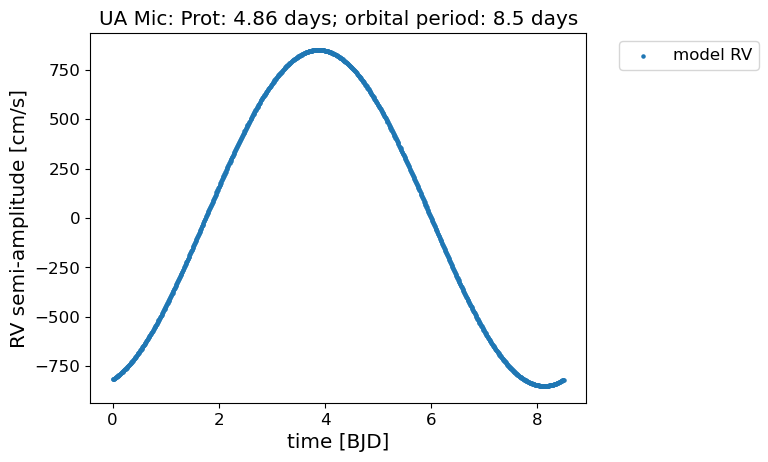

In [20]:
### RV model
start = 2352 # BJD
end = 2552 # BJD
t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
t_phase_folded = t % p
#sigma_val = 30+1e-6 # cm/s
#test_sigma = np.ones(len(test_t))*sigma_val
y = model(t, theta)
y_phase_folded = model(t_phase_folded, theta)

### plot observations from strategy
#end = start + cadence * n_obs
#strat = np.linspace(start, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = np.array(strat) % p

plt.scatter(t_phase_folded, y_phase_folded, s=5, label='model RV')
#plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
#for i in strat_phase_folded:
#    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'UA Mic: Prot: {Prot} days; orbital period: {p} days')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.savefig(f'plots/au-mic/blank_phase_curve.png', format='png', bbox_inches='tight')
plt.show()

### Add correlated noise to RV signal for more realistic depiction of strategies

#### Use celerite to sample from GP prior

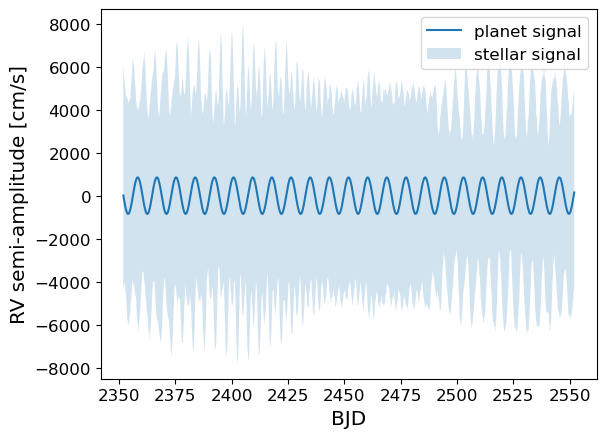

In [21]:
import celerite2
from celerite2 import terms

# quasiperiodic term
#kernel = terms.SHOTerm(sigma=1., rho=1., tau=10.) # S0=1.0, Q=2.5, w0=0.2
kernel = terms.SHOTerm(sigma=sigma_qp_rv, rho=Prot, tau=Tau)

# set up GP
gp = celerite2.GaussianProcess(kernel, mean=0.)
gp.compute(t, yerr=sigma_wn_rv)
sample = gp.sample(size=50)
mu, sigma = np.mean(sample, axis=0), np.std(sample, axis=0)
plt.plot(t, y, label='planet signal')
plt.fill_between(t, mu - sigma, mu + sigma, alpha=0.2, label='stellar signal')
plt.legend()
plt.xlabel('BJD')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.show()

Specific sample

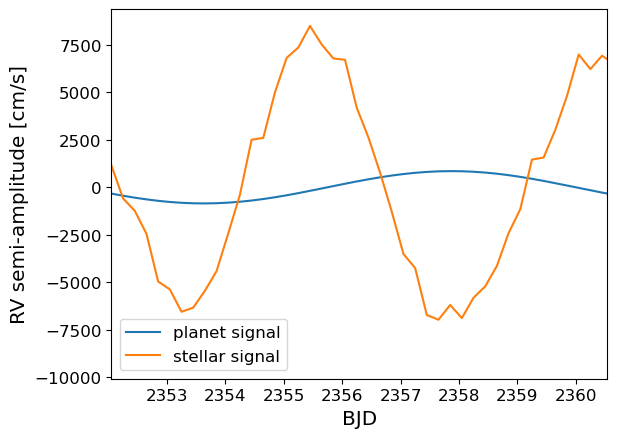

In [41]:
specific_sample = sample[0]
plt.plot(t, y, label='planet signal')
plt.plot(t, specific_sample, label='stellar signal')
plt.legend()
plt.xlabel('BJD')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.xlim([t[0], t[0]+p])
plt.savefig('plots/au-mic/planet-and-stellar-signal.pdf', format='pdf')
plt.show()

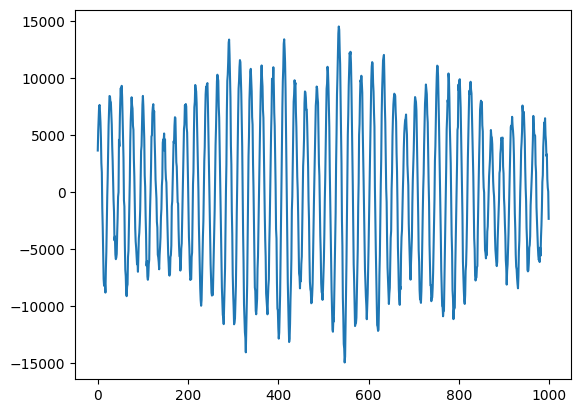

In [421]:
plt.plot(sample[0])

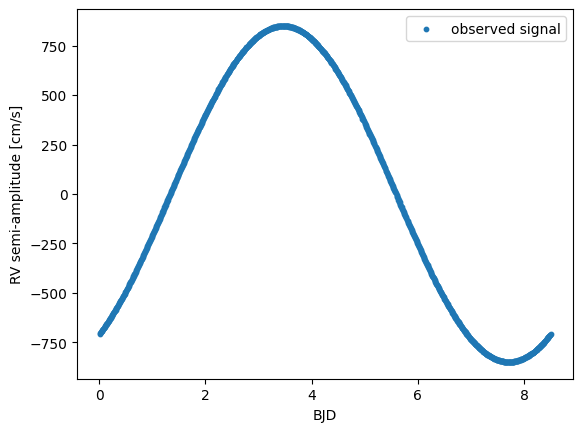

In [418]:
specific_sample = sample[0]

plt.scatter(t % p, y, label='observed signal', s=10)
#plt.scatter(t % p, y+specific_sample, label='observed signal', s=10)
plt.legend()
plt.xlabel('BJD')
plt.ylabel('RV semi-amplitude [cm/s]')
#plt.xlim([t[0], t[0]+p])
plt.show()

Specific example with strategy superimposed

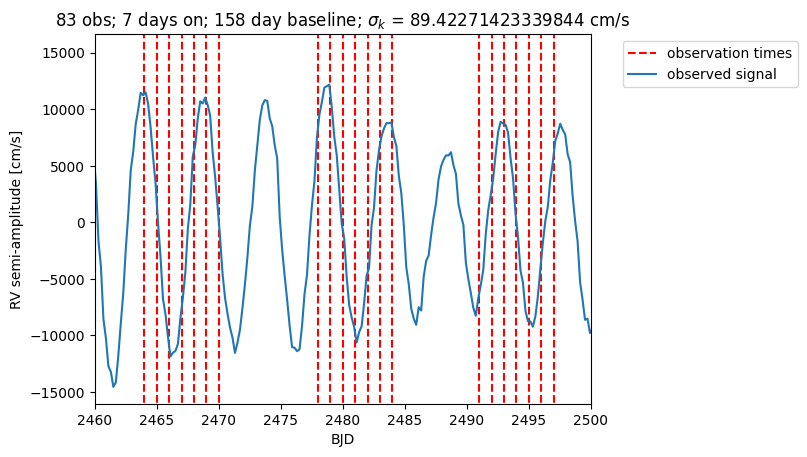

In [355]:
strat_phase_folded = np.array(strat) % p

plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
    
#plt.plot(t, y, label='planet signal')
#plt.plot(t, specific_sample, label='stellar signal')
plt.plot(t, specific_sample + y, label='observed signal')
plt.legend()
plt.xlabel('BJD')
plt.ylabel('RV semi-amplitude [cm/s]')
#plt.xlim([t[0], t[-1]])
#plt.xlim([t[0], t[0]+2*p])
plt.xlim([2460, 2500])
plt.title(f'{n_obs} obs; {on} days on; {baseline} day baseline; ' + r'${\sigma}_k$' + f' = {sigma_k} cm/s')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Now phase-folded

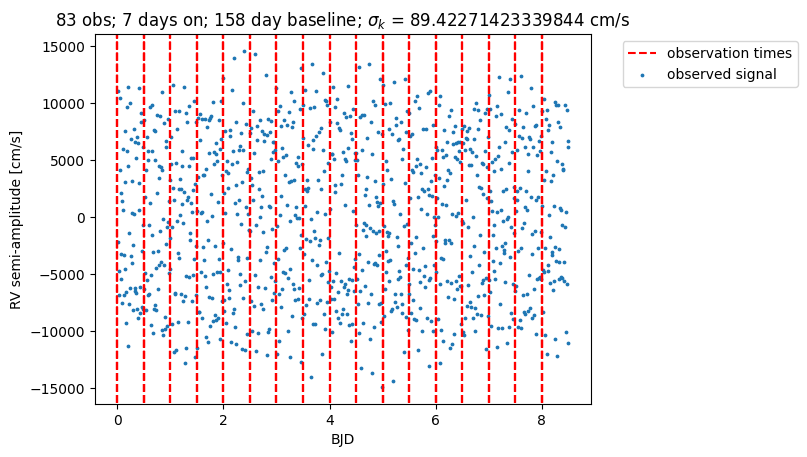

In [371]:
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat:
    plt.axvline(i % p, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
    
specific_sample = sample[0]
#plt.plot(t, y, label='planet signal')
#plt.plot(t, specific_sample, label='stellar signal')
#plt.scatter(t % p, specific_sample + y, label='observed signal', s=3)
#plt.scatter(t[:40] % Prot, specific_sample[:40], label='observed signal', s=3)
plt.scatter(t % p, specific_sample, label='observed signal', s=3)
plt.legend()
plt.xlabel('BJD')
plt.ylabel('RV semi-amplitude [cm/s]')
#plt.xlim([t[0], t[-1]])
#plt.xlim([t[0], t[0]+2*p])
#plt.xlim([2460, 2500])
plt.title(f'{n_obs} obs; {on} days on; {baseline} day baseline; ' + r'${\sigma}_k$' + f' = {sigma_k} cm/s')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Bin down the RV data, as done by Plavchan+2020 with the big red circles

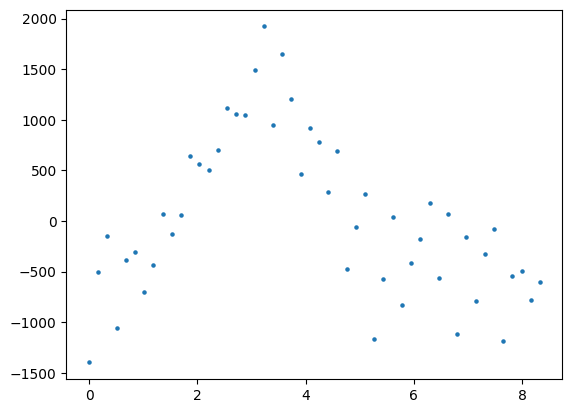

In [394]:
from scipy.stats import binned_statistic

mean_stat = binned_statistic(t % p, specific_sample + y, 
                             statistic='mean', 
                             bins=50, range=(0, p))

#print(mean_stat.statistic)
#print(mean_stat.bin_edges)
#print(mean_stat.binnumber)

plt.scatter(mean_stat.bin_edges[:-1], mean_stat.statistic, s=5)

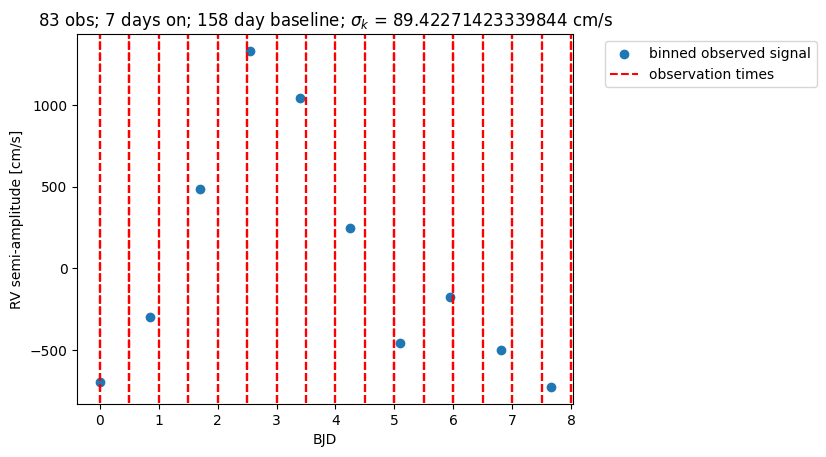

In [404]:
from scipy.stats import binned_statistic

mean_stat = binned_statistic(t % p, specific_sample + y, 
                             statistic='mean', 
                             bins=10, range=(0, p))

#print(mean_stat.statistic)
#print(mean_stat.bin_edges)
#print(mean_stat.binnumber)

plt.scatter(mean_stat.bin_edges[:-1], mean_stat.statistic, label='binned observed signal')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat:
    plt.axvline(i % p, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
    
plt.legend()
plt.xlabel('BJD')
plt.ylabel('RV semi-amplitude [cm/s]')
#plt.xlim([t[0], t[-1]])
#plt.xlim([t[0], t[0]+2*p])
#plt.xlim([2460, 2500])
plt.title(f'{n_obs} obs; {on} days on; {baseline} day baseline; ' + r'${\sigma}_k$' + f' = {sigma_k} cm/s')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

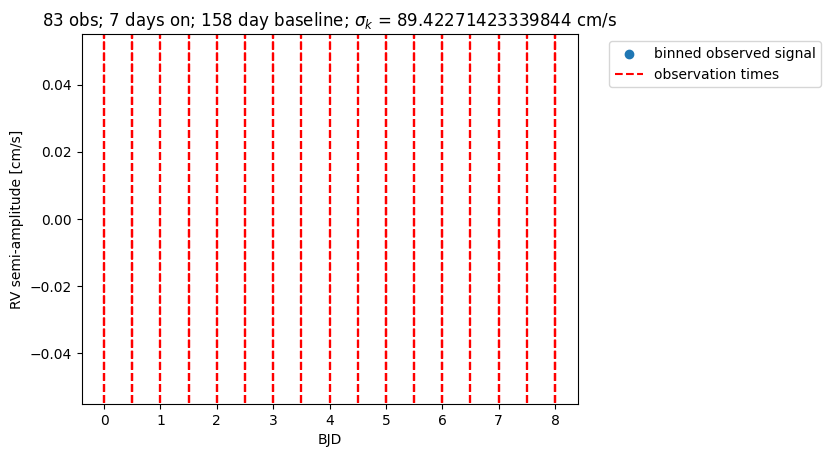

In [403]:
from scipy.stats import binned_statistic

mean_stat = binned_statistic(t, specific_sample + y, 
                             statistic='mean', 
                             bins=10, range=(0, p))

#print(mean_stat.statistic)
#print(mean_stat.bin_edges)
#print(mean_stat.binnumber)

plt.scatter(mean_stat.bin_edges[:-1] % p, mean_stat.statistic, label='binned observed signal')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat:
    plt.axvline(i % p, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
    
plt.legend()
plt.xlabel('BJD')
plt.ylabel('RV semi-amplitude [cm/s]')
#plt.xlim([t[0], t[-1]])
#plt.xlim([t[0], t[0]+2*p])
#plt.xlim([2460, 2500])
plt.title(f'{n_obs} obs; {on} days on; {baseline} day baseline; ' + r'${\sigma}_k$' + f' = {sigma_k} cm/s')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

And by Prot

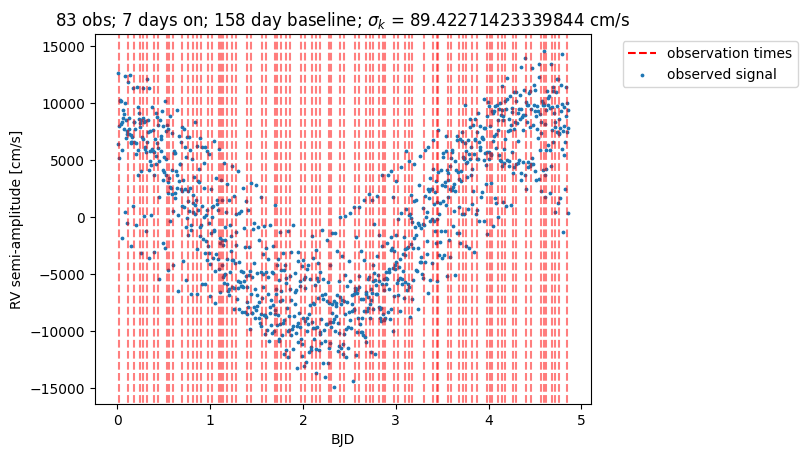

In [373]:
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat:
    plt.axvline(i % Prot, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r', alpha=0.5)
    
specific_sample = sample[0]
#plt.plot(t, y, label='planet signal')
#plt.plot(t, specific_sample, label='stellar signal')
#plt.scatter(t % p, specific_sample + y, label='observed signal', s=3)
#plt.scatter(t[:40] % Prot, specific_sample[:40], label='observed signal', s=3)
plt.scatter(t % Prot, specific_sample, label='observed signal', s=3)
plt.legend()
plt.xlabel('BJD')
plt.ylabel('RV semi-amplitude [cm/s]')
#plt.xlim([t[0], t[-1]])
#plt.xlim([t[0], t[0]+2*p])
#plt.xlim([2460, 2500])
plt.title(f'{n_obs} obs; {on} days on; {baseline} day baseline; ' + r'${\sigma}_k$' + f' = {sigma_k} cm/s')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

### Cadence vs number of observations

White noise case

In [68]:
fim = calculate_fim(strat, sigma, theta)
inv_fim = inv(fim)
sigma_k = np.sqrt(inv_fim)[0][0]
print(sigma_k)

args = np.array(strat), sigma**2, jnp.array(theta, dtype=float) # sigma**2 is the key for white noise
fim = clam_jax_fim(*args)#.block_until_ready()
inv_fim = inv(fim)
sigma_k = np.sqrt(inv_fim)[0][0]
print(sigma_k)

106.10295542534358
106.10312


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_27786/3952970788.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_27786/1243494532.py:3: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_27786/1243494532.py:9: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


In [141]:
sigma_ks = []
c = 1 # once per day

for n_obs in range(100)[4:]:
    strat = gappy(n_obs, c, start, offs=[], dropout=0.)

    sigma = np.diag(sigma_wn_rv*np.ones(len(strat)))

    args = np.array(strat), sigma**2, jnp.array(theta, dtype=float)
    fim = clam_jax_fim(*args).block_until_ready()
    inv_fim = inv(fim)
    sigma_k = np.sqrt(inv_fim)[0][0]
    sigma_ks.append(sigma_k)
    


/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_27786/3464625255.py:12: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


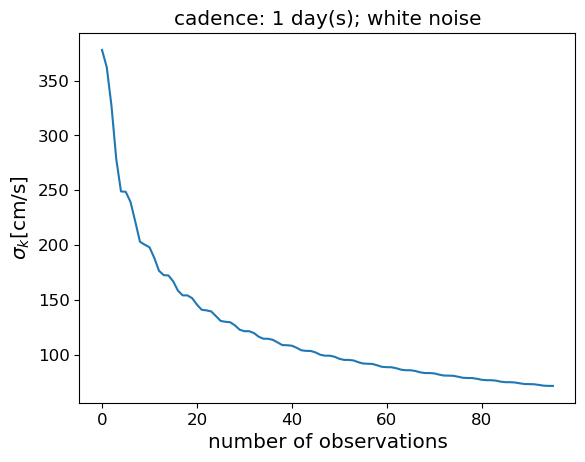

In [145]:
plt.plot(range(len(sigma_ks)), sigma_ks)
#plt.plot(range(len(sigma_k_stable_test)), sigma_k_stable_test, label='not using inv')
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[cm/s]")
plt.title(f"cadence: {c} day(s); white noise")
plt.savefig(path + f"plots/au-mic/n_obs.png", format="png")
plt.show()

In [146]:
#n_ons = np.linspace(1, 16, 16) # the number of consecutive nights of observing before going to off-mode
#baselines = np.linspace(31, 180, 150) # the total calendar time of the observing campaign (let's say max of 6 months, or 180 days)
#n_ons = np.linspace(3, 16, 14)
#baselines = np.linspace(35, 60, 26) 

# planet observation parameters
#periods = np.linspace(1, 30, 200)
#cadences = np.linspace(1, 7, 200)

# white noise parameter
sigma_wn_rv = 5 * 1e2 # [cm/s]

p = 8.5 # p_c = 18.9 days
Prot = 4.86 # days
K = 580 # cm/s

### the parameter I'm varying
params = [Tau, eta, Prot, sigma_qp_rv, sigma_wn_rv]

#periods = [p]
#cadences = np.linspace(0.30, 6.85, 100)
#n_obs = 30 #40 # 500
start = 2352
dim = 100
n_observations = np.linspace(3, 102, dim).astype(int)
cadences = np.linspace(0.30, 6.85, dim)

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

sigma_ks = np.ones(len(n_observations)*len(cadences)).reshape((len(n_observations),len(cadences)))
fi_ks = np.ones(len(n_observations)*len(cadences)).reshape((len(n_observations),len(cadences)))

for enum_o, o in enumerate(tqdm(n_observations)):
    for enum_c, c in enumerate(cadences):
                
        try:
            strat = gappy(o, c, start, offs=[], dropout=0.)
            #print("strat: ", strat, "length: ", len(strat))
        
            ### calculate FI and sigma_K
            sigma = np.diag(sigma_wn_rv*np.ones(len(strat))) # white noise
            sigma += 1e-6 
            #sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM

            args = np.array(strat), sigma**2, jnp.array(theta, dtype=float)
            #fim = dfms_jax_version(*args).block_until_ready()
            fim = clam_jax_fim(*args).block_until_ready()
            inv_fim = inv(fim)
            sigma_k = np.sqrt(inv_fim)[0][0]

            fi_k = fim[0][0]

            # for 2D plots and testing
            sigma_ks[enum_o][enum_c] = sigma_k
            ###sigma_ks_stable[enum1][enum2] = sigma_k_stable
            ###sigma_ks_solve[enum1][enum2] = sigma_k_solve

            fi_ks[enum_o][enum_c] = fi_k
                
        except Exception as e:
            print(e, o, c)
            sigma_ks[enum_o][enum_c] = np.nan
            fi_ks[enum_o][enum_c] = 0

  0%|                                                                                                                                                                          | 0/100 [00:00<?, ?it/s]/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_27786/3852060257.py:52: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.62it/s]


In [148]:
path

'/Users/chrislam/Desktop/scheduling'

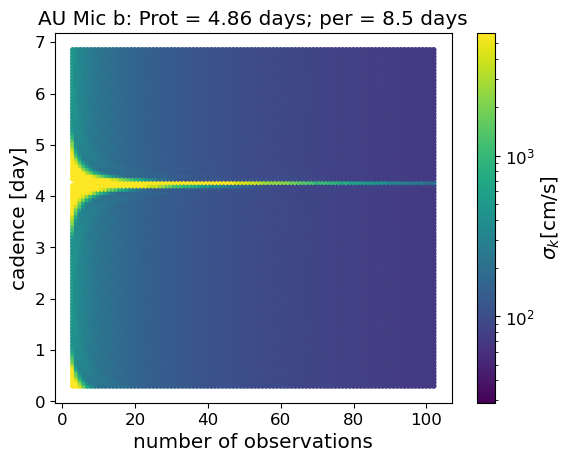

In [150]:
x, y = np.meshgrid(cadences, n_observations)
#plt.scatter(x, y, c=np.sqrt(fi_ks), s=5, norm=matplotlib.colors.LogNorm()) # vmin=1e2, vmax=3e4
plt.scatter(y, x, c=sigma_ks, s=10, norm=matplotlib.colors.LogNorm(vmin=0.05*K, vmax=10*K)) # vmin=5, vmax=35
#plt.scatter(y, x, c=sigma_ks, s=5) # vmin=5, vmax=35
#cbar.ax.set_ylabel(r'$\sqrt{FI_K}$')
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("time between observations [day]")
#plt.yscale('log')
plt.title(f"AU Mic b: Prot = {Prot} days; per = {p} days")
plt.savefig(path + f"plots/au-mic/n_obs-vs-cadence-white.png", format="png")
plt.show()


Correlated noise

In [151]:
#n_ons = np.linspace(1, 16, 16) # the number of consecutive nights of observing before going to off-mode
#baselines = np.linspace(31, 180, 150) # the total calendar time of the observing campaign (let's say max of 6 months, or 180 days)
#n_ons = np.linspace(3, 16, 14)
#baselines = np.linspace(35, 60, 26) 

# planet observation parameters
#periods = np.linspace(1, 30, 200)
#cadences = np.linspace(1, 7, 200)

# correlated noise parameters, from Klein+ 2021 for AU Mic
Tau = 100/np.sqrt(2) # active region lifetime; days
eta = 0.4/np.sqrt(2) # 0.1, 0.3, 0.58, 0.9 # smoothing parameter
sigma_qp_rv = 47 * 1e2 # modified Jeffreys prior +11, -8 [cm/s]
sigma_wn_rv = 5 * 1e2 # [cm/s]

p = 8.5 # p_c = 18.9 days
Prot = 4.86 # days
K = 580 # cm/s

### the parameter I'm varying
params = [Tau, eta, Prot, sigma_qp_rv, sigma_wn_rv]

#periods = [p]
#cadences = np.linspace(0.30, 6.85, 100)
#n_obs = 30 #40 # 500
start = 2352
dim = 100
n_observations = np.linspace(3, 102, dim).astype(int)
cadences = np.linspace(0.30, 6.85, dim)

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

sigma_ks = np.ones(len(n_observations)*len(cadences)).reshape((len(n_observations),len(cadences)))
fi_ks = np.ones(len(n_observations)*len(cadences)).reshape((len(n_observations),len(cadences)))

for enum_o, o in enumerate(tqdm(n_observations)):
    for enum_c, c in enumerate(cadences):
        
        #o, c = int(o), int(c)
        
        try:
            strat = gappy(o, c, start, offs=[], dropout=0.)
            #print("strat: ", strat, "length: ", len(strat))
        
            ### calculate FI and sigma_K
            sigma = cov_matrix(strat, params)
            sigma += 1e-6 
            #sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM

            args = np.array(strat), sigma, jnp.array(theta, dtype=float)
            #fim = dfms_jax_version(*args).block_until_ready()
            fim = clam_jax_fim(*args).block_until_ready()
            inv_fim = inv(fim)
            sigma_k = np.sqrt(inv_fim)[0][0]

            fi_k = fim[0][0]

            # for 2D plots and testing
            sigma_ks[enum_o][enum_c] = sigma_k
            ###sigma_ks_stable[enum1][enum2] = sigma_k_stable
            ###sigma_ks_solve[enum1][enum2] = sigma_k_solve

            fi_ks[enum_o][enum_c] = fi_k
                
        except Exception as e:
            print(e, o, c)
            sigma_ks[enum_o][enum_c] = np.nan
            fi_ks[enum_o][enum_c] = 0

  0%|                                                                                                                                                                          | 0/100 [00:00<?, ?it/s]/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_27786/1204227737.py:57: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:34<00:00,  2.14s/it]


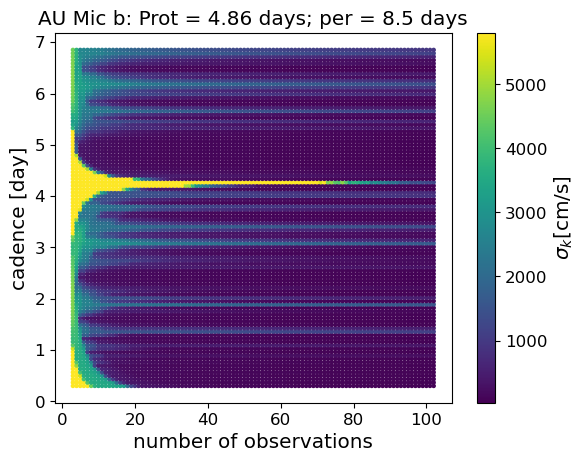

In [152]:
x, y = np.meshgrid(cadences, n_observations)
#plt.scatter(x, y, c=np.sqrt(fi_ks), s=5, norm=matplotlib.colors.LogNorm()) # vmin=1e2, vmax=3e4
#plt.scatter(y, x, c=sigma_ks, s=5, norm=matplotlib.colors.LogNorm(vmin=0.05*K, vmax=K)) # vmin=5, vmax=35
plt.scatter(y, x, c=sigma_ks, s=5, vmin=0.05*K, vmax=10*K)
#cbar.ax.set_ylabel(r'$\sqrt{FI_K}$')
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("time between observations [day]")
#plt.yscale('log')
plt.title(f"AU Mic b: Prot = {Prot} days; per = {p} days")
plt.savefig(path + f"plots/au-mic/n_obs-vs-cadence-correlated.png", format="png")
plt.show()

### Orbital period and cadence

Let's say AU Mic is a representative of young, cool stars. We can then swap in different single planets and generate a sensitivity map for orbital period vs observing cadence. 

In [159]:
# correlated noise parameters, from Klein+ 2021 for AU Mic
Tau = 100/np.sqrt(2) # active region lifetime; days
eta = 0.4/np.sqrt(2) # 0.1, 0.3, 0.58, 0.9 # smoothing parameter
sigma_qp_rv = 47 * 1e2 # modified Jeffreys prior +11, -8 [cm/s]
sigma_wn_rv = 5 * 1e2 # [cm/s]

p = 8.5 # p_c = 18.9 days
Prot = 4.86 # days
K = 580 # cm/s

### the parameter I'm varying
params = [Tau, eta, Prot, sigma_qp_rv, sigma_wn_rv]

#n_obs = 30 #40 # 500
start = 2352
dim = 100
# planet observation parameters
periods = np.logspace(0, 2, dim)
cadences = np.linspace(0.30, 6.85, dim)
n_obs = 30 #70

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []

sigma_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))
fi_ks = np.ones(len(periods)*len(cadences)).reshape((len(periods),len(cadences)))

for enum_o, o in enumerate(tqdm(periods)):
    for enum_c, c in enumerate(cadences):
                
        try:
            strat = gappy(n_obs = n_obs, cadence = c, start = start, offs=[], dropout=0.)
            #print("strat: ", strat, "length: ", len(strat))
        
            ### calculate FI and sigma_K
            sigma = cov_matrix(strat, params)
            sigma += 1e-6 
            #sigma = inv(sigma) # I want the inverse of the covariance matrix for FIM

            theta = [K, p, T0]
            args = np.array(strat), sigma, jnp.array(theta, dtype=float)
            #fim = dfms_jax_version(*args).block_until_ready()
            fim = clam_jax_fim(*args).block_until_ready()
            inv_fim = inv(fim)
            sigma_k = np.sqrt(inv_fim)[0][0]

            fi_k = fim[0][0]

            # for 2D plots and testing
            sigma_ks[enum_o][enum_c] = sigma_k
            ###sigma_ks_stable[enum1][enum2] = sigma_k_stable
            ###sigma_ks_solve[enum1][enum2] = sigma_k_solve

            fi_ks[enum_o][enum_c] = fi_k
                
        except Exception as e:
            print(e, o, c)
            sigma_ks[enum_o][enum_c] = np.nan
            fi_ks[enum_o][enum_c] = 0

  0%|                                                                                                                                                                          | 0/100 [00:00<?, ?it/s]/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_27786/2464805855.py:47: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.91it/s]


In [160]:
sigma_ks

array([[ 233.46592712,  163.85839844,  159.07025146, ..., 1144.61853027,
        1844.83422852, 1596.26171875],
       [ 232.95935059,  163.69241333,  159.08969116, ..., 1144.57885742,
        1845.55358887, 1597.15014648],
       [ 232.91583252,  163.56260681,  159.03588867, ..., 1144.71459961,
        1845.15112305, 1595.83532715],
       ...,
       [ 233.614151  ,  165.395401  ,  159.09542847, ..., 1143.38061523,
        1844.55395508, 1596.86291504],
       [ 233.42539978,  164.33447266,  158.90911865, ..., 1145.26513672,
        1844.89697266, 1596.4798584 ],
       [ 232.97993469,  165.24647522,  159.21601868, ..., 1144.35205078,
        1844.98535156, 1598.58129883]])

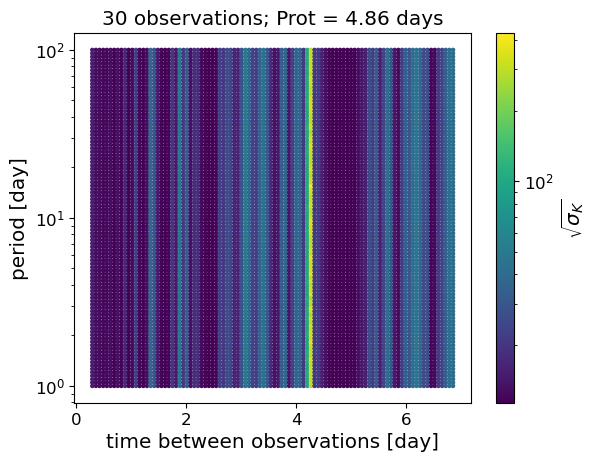

In [161]:
x, y = np.meshgrid(cadences, periods)
plt.scatter(x, y, c=np.sqrt(sigma_ks), s=5, norm=matplotlib.colors.LogNorm()) # vmin=1e5, vmax=1e10
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sqrt{\sigma_K}$")
plt.xlabel("time between observations [day]")
plt.ylabel("period [day]")
#plt.ylim([0, 100])
plt.yscale('log')
plt.title(f"{n_obs} observations; Prot = {Prot} days")
#plt.savefig(path + f"plots/au-mic/cadence-vs-period.png", format="png")
plt.show()

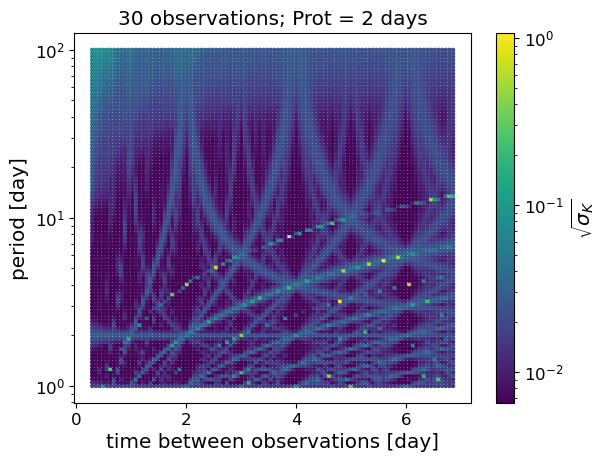

In [163]:
x, y = np.meshgrid(cadences, periods)
plt.scatter(x, y, c=np.sqrt(sigma_ks), s=5, norm=matplotlib.colors.LogNorm()) # vmin=1e5, vmax=1e10
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sqrt{\sigma_K}$")
plt.xlabel("time between observations [day]")
plt.ylabel("period [day]")
#plt.ylim([0, 100])
plt.yscale('log')
plt.title(f"{n_obs} observations; Prot = {Prot} days")
plt.show()

### Two-planet case: introducing, AU Mic c

In [1]:
def model_multi(t, thetas): 
    """
    Radial velocity model, given timestamps and planetary orbital parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]

    """
    
    rv_total = 0
    for theta in thetas:
        K, P, T0 = theta[0], theta[1], theta[2]
        arg = (2*np.pi/P)*(t-T0)
    
        rv = -K * np.sin(arg)
        rv_total += rv
    
    return rv_total



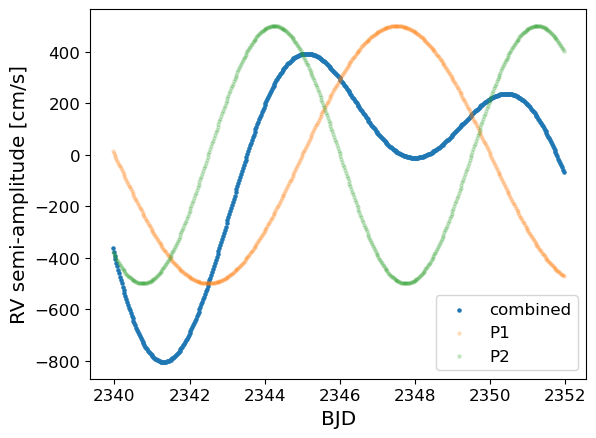

In [24]:
test_t = np.linspace(start, 2340, 500) + np.random.normal(0, 1./24)
test_P1 = 10
test_P2 = 7
test_theta = [test_K, test_P1, test_P2, test_T0]

test_thetas = [[test_K, test_P1, test_T0], [test_K, test_P2, test_T0]]
y = model_multi(test_t, test_thetas)
plt.scatter(test_t, y, s=5, label='combined')
plt.scatter(test_t, model(test_t, [test_K, test_P1, test_T0]), s=5, alpha=0.2, label='P1')
plt.scatter(test_t, model(test_t, [test_K, test_P2, test_T0]), s=5, alpha=0.2, label='P2')

plt.xlabel('BJD')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.legend()
plt.show()